In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

# Данные

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

In [2]:
df = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print('shape: ', df.shape)

shape:  (284, 1)


C:\Users\andrp\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


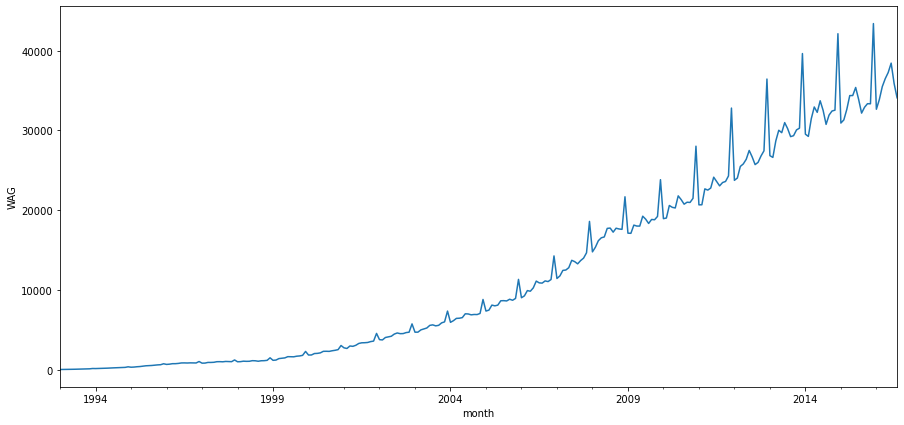

In [4]:
plt.figure(figsize=(15,7))
df.WAG_C_M.plot()
plt.ylabel('WAG')
plt.show()

Хорошо виден возрастающий тренд; выраженная сезонность во второй половине графика.

Проверка стационарности и STL-декомпозиция ряда

Критерий Дики-Фуллера: 0.9918495954854735


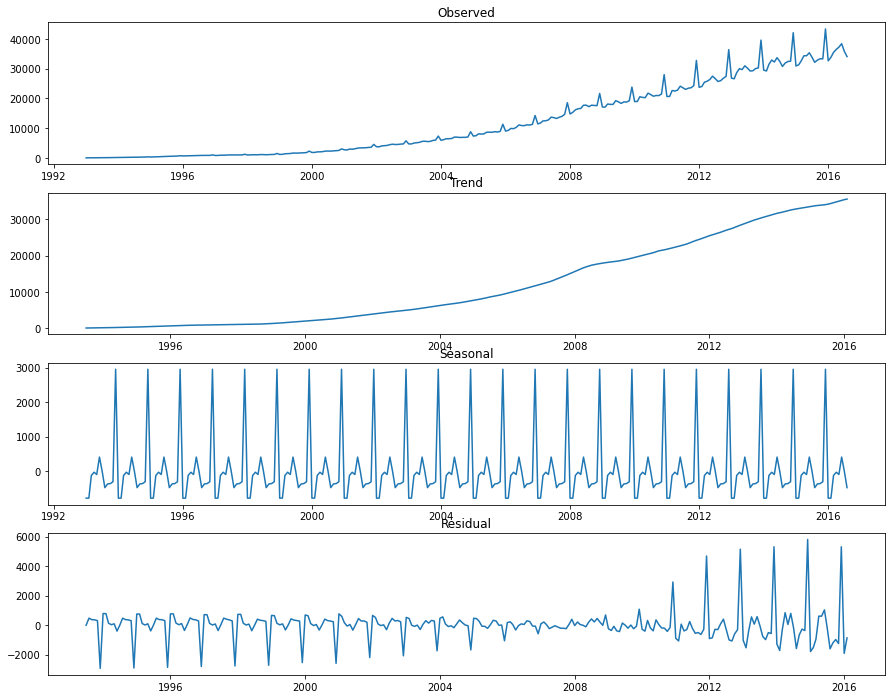

In [5]:
def plot_decomposition(data):
    fig, axes = plt.subplots(4,1,figsize=(15,12))
    stl_decompose = sm.tsa.seasonal_decompose(data)
    axes[0].plot(data)
    axes[0].set_title('Observed')
    axes[1].plot(stl_decompose.trend)
    axes[1].set_title('Trend')
    axes[2].plot(stl_decompose.seasonal)
    axes[2].set_title('Seasonal')
    axes[3].plot(stl_decompose.resid)
    axes[3].set_title('Residual')
    
plot_decomposition(df.WAG_C_M)
# sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(df.WAG_C_M)[1]))

Хорошо выраженные тренд и сезонность.

# Стабилизация дисперсии

Сделаем стабилизацию дисперсии методом Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p=0.6968987634832662


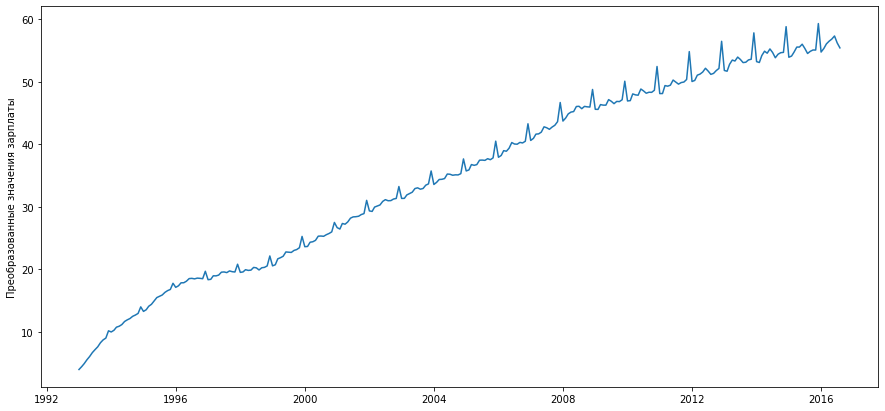

In [6]:
df['WAG_C_M_box'], lmbda = stats.boxcox(df.WAG_C_M)


plt.figure(figsize=(15,7))
plt.plot(df.WAG_C_M_box)
plt.ylabel('Преобразованные значения зарплаты')
print('Оптимальный параметр преобразования Бокса-Кокса: {}'.format(lmbda))
print('Критерий Дики-Фуллера: p={}'.format(
    sm.tsa.stattools.adfuller(df.WAG_C_M_box)[1]))

# Стационарность

Попробуем достичь стабилизацию путем сезонного дифференцирования

Критерий Дики-Фуллера: p=0.014697133494791775


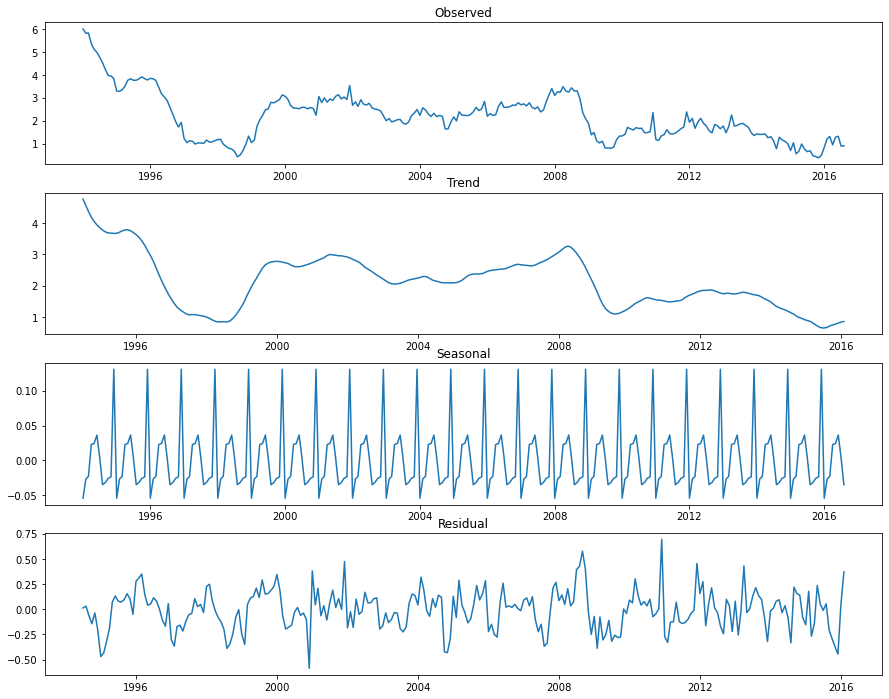

In [7]:
df['WAG_C_M_box_diff'] = df['WAG_C_M_box'] - df['WAG_C_M_box'].shift(12)
plot_decomposition(df.WAG_C_M_box_diff[12:])
print('Критерий Дики-Фуллера: p={}'.format(
    sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff[12:])[1]))

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Добавим обычное дифференцирование

Критерий Дики-Фуллера: p=5.203603715821937e-08


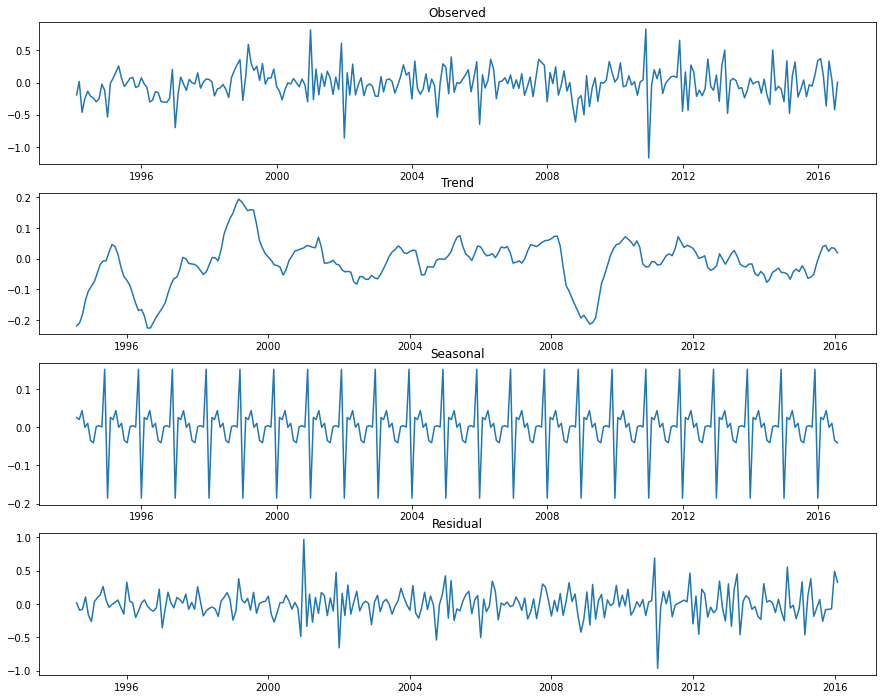

In [8]:
df['WAG_C_M_box_diff2'] = df.WAG_C_M_box_diff - df.WAG_C_M_box_diff.shift(1)
plot_decomposition(df.WAG_C_M_box_diff2[13:])
print('Критерий Дики-Фуллера: p={}'.format(
    sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff2[13:])[1]))

Гипотеза нестационарности отвергается. Избавились от возрастающего тренда, теперь данные на графике тренда колеблятся вокруг нуля.

# Подбор модели

Построим графики автокорреляции и частичной автокорреляции для подбора параметров модели SARIMAX(p,d,q)x(P,D,Q)

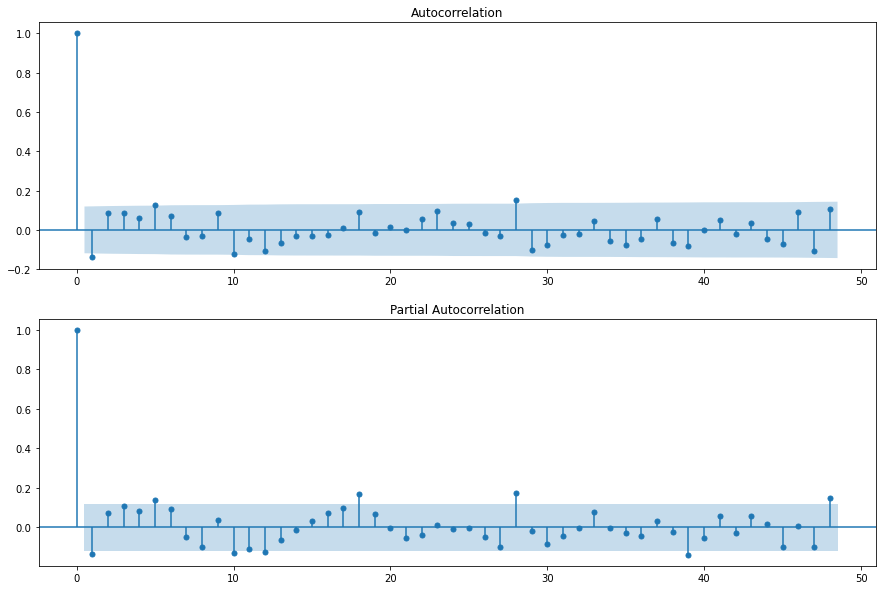

In [9]:
plt.figure(figsize=(15,10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные параметры: Q = 0, q = 1, P = 1, p = 1

In [10]:
ps = range(0, 2)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

In [11]:
parameters_list = list(product(ps, qs, Ps, Qs))
len(parameters_list)

8

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df.WAG_C_M_box,
                                          order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
# warnings.filterwarnings('default')

Wall time: 1.07 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


In [14]:
# Лучшая модель
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 24 Mar 2022   AIC                              0.341
Time:                                    17:54:50   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090793062950923
Критерий Дики-Фуллера: p=3.4594036533247205e-06


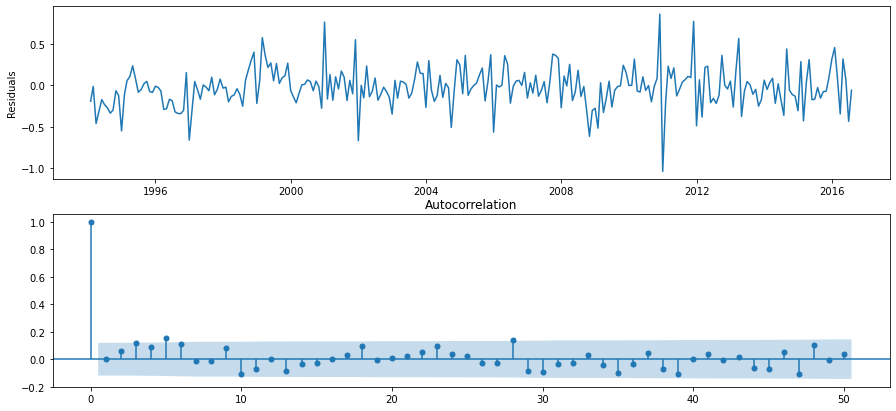

In [15]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(best_model.resid[13:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print('Критерий Стьюдента: p={}'.format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

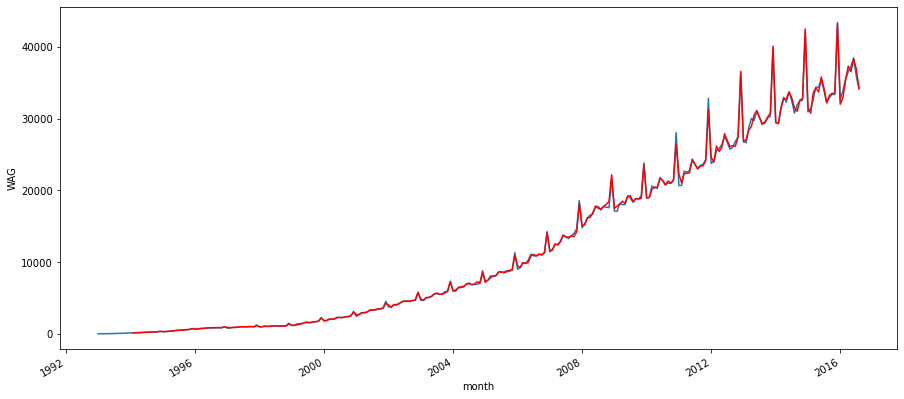

In [16]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot(df.WAG_C_M)
df.model[13:].plot(color='r')
plt.ylabel('WAG')
plt.show()

# Прогноз

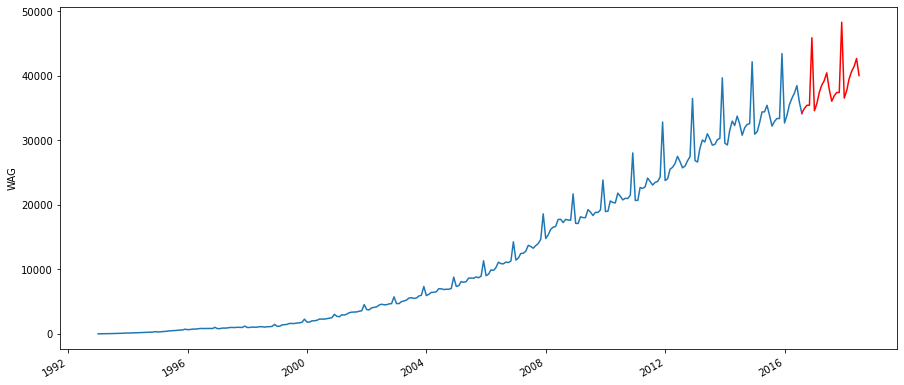

In [17]:
import datetime
from dateutil.relativedelta import relativedelta

df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start="2016-08-01", end="2019-08-01"), lmbda)

plt.figure(figsize=(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('WAG')
plt.show()